In [1]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import matplotlib.pyplot as plt

<Axes: >

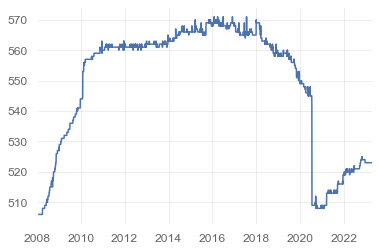

In [2]:
universe = master.baskets.get_index_historical_components('GSPC')
P = func.presence_matrix(universe).loc['2008':]
P.sum(1).plot()

In [3]:
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
# P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
income_statement = pd.read_parquet('data/US/income_statement.pq')

STRAT EQUITY MULTIPLE

EV = Market Capitalization + (longTermDebt + shortTermDebt) – cashAndEquivalents

In [4]:
mkt_cap = market_data['MktCap'].unstack().reindex_like(P).astype(float)
ltdebt = balance_sheet['longTermDebt'].unstack().reindex_like(P).ffill().astype(float)
stdebt = balance_sheet['shortTermDebt'].unstack().reindex_like(P).ffill().astype(float)
cash_equiv = balance_sheet['cashAndEquivalents'].unstack().reindex_like(P).ffill().astype(float)

EV = mkt_cap + (ltdebt+stdebt)  - cash_equiv.fillna(0)
ebitda = income_statement['ebitda'].unstack().reindex_like(P).ffill().astype(float)

EM = EV / ebitda
# EM = EM.sub(EM.mean(1),0).div(EM.std(1),0)

C:\Users\marti\AppData\Local\Temp\ipykernel_80348\3575834318.py:2: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  signal = signal[P].rolling(365).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99)
C:\Users\marti\AppData\Local\Temp\ipykernel_80348\3575834318.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)


Sharpe      1.5
Turnover    0.1
biais       1.5
dtype: float64

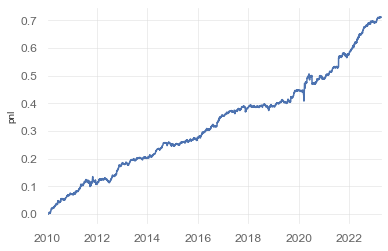

In [6]:
signal = EM[P].rank(1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf).ffill()
signal = signal[P].rolling(365).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99)
signal = signal[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
signal[signal.abs()<0.5] = None

signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)
signal = signal[P].div(signal.abs().sum(1),0)


pnl = (signal[P].shift()*R).sum(1).loc['2010':]
sr = sharpe(pnl)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
pnl.cumsum().plot()

plt.ylabel('pnl')
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':pnl.mean()*1e4}).round(1)


C:\Users\marti\AppData\Local\Temp\ipykernel_13720\2151823176.py:11: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  signal = signal[P].rolling(15).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99)
C:\Users\marti\AppData\Local\Temp\ipykernel_13720\2151823176.py:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicind'],axis=1).apply(center)


Sharpe      0.8
Turnover    0.7
biais       1.1
dtype: float64

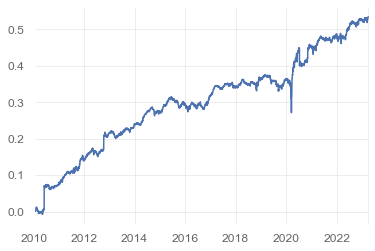

In [74]:
totalAssets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)
totalLiabilities = balance_sheet['totalLiab'].unstack().reindex_like(P).ffill().astype(float)
book_value = totalAssets - totalLiabilities

shares = balance_sheet['commonStockSharesOutstanding'].unstack().reindex_like(P).ffill().astype(float)

book_value_share = book_value/ shares
adj_close = market_data['close'].unstack().reindex_like(P).astype(float)
PB_ratio = adj_close/book_value_share
signal = PB_ratio[P].rank(1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf).ffill()
signal = signal[P].rolling(15).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99)
signal = signal[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
signal[signal.abs()<0.5] = None

signal = signal[P].groupby(GICS['gicind'],axis=1).apply(center)
signal = signal[P].div(signal.abs().sum(1),0)


pnl_pb = (signal[P].shift()*R).sum(1).loc['2010':]
sr = sharpe(pnl_pb)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
pnl_pb.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':pnl_pb.mean()*1e4}).round(1)

Sharpe    1.582966
dtype: float64

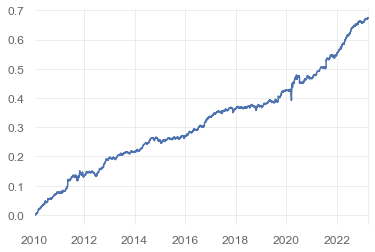

In [71]:
pnl = (signal.shift()*R).sum(1).loc['2010':]
sr = sharpe(pnl)
pnl.cumsum().plot()
pd.Series({'Sharpe':sr})

<Axes: xlabel='Date'>

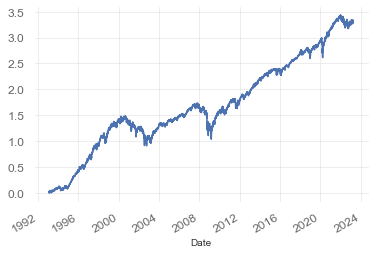

In [72]:
import quantstats as qs
sp500 = qs.utils.download_returns('SPY')
sp500.cumsum().plot()

In [75]:
qs.reports.html(pnl,pnl_pb,rf=0,title ='EM Momentum, vs PB momentum',download_filename='strat EM MOMENTUM,vs PB momentum')

AttributeError: 'NoneType' object has no attribute 'upper'